# Multi-Orientation MAXWELL; Example Protocol
<b> Authored by Sierra Dean<br>
06 December 2024<br>
email: ccnd@live.com</b>
<div class="alert alert-block alert-info">
This document serves as a general walkthrough of how to use the Multi-Orientation MAXWELL analysis method. In addition to custom software hosted as various python classes, simulated data is provided to ensure a thorough understanding of the software capabilities.<br>
Software:<br>
<i>https://github.com/SierraD/Multi-Orientation-Maxwell/</i><br>
Simulated Data: <br>
<i>https://figshare.com/authors/Sierra_Dean/20319102</i><br>
For this example, all classes composing the Multi-Orientation MAXWELL software are copied directly from the online repository into Jupyter Notebook cells. The classes can also be ran through the command line interface. Both the code, as well as the output, are recorded here as a general recommendation on how to execute the analysis method.
</div>

<div class="alert alert-block alert-success">
The data used in this example is scintillation events simulated from ThunderSTORM. The example data uses a pixel size of 230 nm, which simulates a 20x magnification lens, and a 25 nm step between images, depicting the in-depth pixel size. The scintillation events have a FWHM between 2-5 pixels in size, with intensity between 10000-20000 photons per event.
</div>

# Imports

In [1]:
# Used in Preparation;
import pandas
# Used in Overlap;
import numpy
# Used in Plotting;
import plotly
from plotly import subplots
# Used in Precision;
import fitter
import matplotlib
import seaborn
import scipy

# Preparation;

<div class="alert alert-block alert-info">
This class is used to format the two different orientation ThunderSTORM result files into readable data that can be called by the other classes in the software.<br>
The input for this class is two different orientation ThunderSTORM results files, namely XY and XZ. When performing ThunderSTORM analysis, the pixel size parameter is set to 1 to accommodate the asymmetric voxel size between the two different orientations. This class is used to correct the isotropic voxel size to the correct nanometer units, which requires input of the in-plane pixel size, obtained from the camera and magnification, as well as the in-depth pixel size, which is the step distance between successive images. These are titled as pixelsize_xy and pixelsize_xz, respectively. <br>
his class also enables re-centering the data around zero, and limiting the data to a dedicated ROI to reduce the computation time. <br>
</div>

In [2]:
class preparation(object):
    """
    This file is part of the Multi-Orientation MAXWELL software
    
    File author(s): Sierra Dean <ccnd@live.com>
    
    Distributed under the GPLv3 Licence.
    See accompanying file LICENSE.txt or copy at
        http://www.gnu.org/licenses/gpl-3.0.html
        
    source: https://github.com/SierraD/Multi-Orientation-Maxwell
    
    Last Updated: Sept 26 2024
    """
    def __init__(self):
        """
        A technique to prepare multi two-dimensional ThunderSTORM analysis files for three-dimensional
        analysis. 
        
        This method requires two different orientation files obtained from ThunderSTORM, containing
        two-dimensional pixel-value localizations, and requires the user to input the voxel size
        of the images by defining the in-plane pixel size, as well as the in-depth step size between 
        subsequent images. 
        
        The values in the ThunderSTORM files will then be corrected from pixel size to the nanometer
        scale, and can be set to a zero position, or limited to a user-defined region of interest, 
        as well as downloaded as a CSV file.
        
        Attributes:
            None.
            
        Return: 
            None.
        """
        return 
    
    def setting(self, file_xy, file_xz, magnification=20, pixelsize_xy=230, pixelsize_xz=13, TS_dims = 2):
        """
        A technique to download two different orientation two-dimensional ThunderSTORM analysis files
        and correct the scale from pixel size to nanometers.
                
        Attributes:
        file_xy & file_xz: str "XY_File.csv", "XZ_File.csv", etc.
            The name of the ThunderSTORM results table obtained from the XY and XZ orientations. 
        magnification: int
            The magnification of the lens used to obtain the images. If not specified, 20x magnification 
            will be assumed. 
        pixelsize_xy: int 
            The pixel size of the XY data in nm, calculated using the camera's pixel size, divided by 
            the magnification.
            Example) Hamamatsu Quest at 20x magnificaiton = 4600 [nm] / 20 = 230 [nm] 
                    If not specified, this will be the value assumed.
        pixelsize_xz: int
            The Z step size in nm between images obtained from the LSM.
            If not specified, 13 nm will be assumed.
        TS_dims: 2 or 3
            The number of positional dimensions specified in ThunderSTORM using the Z-stage Offset Menu. 
            If the third dimension was previously specified with correct Z step, no voxel adjustments will 
            be made.
            
        Return:
            None. Will modify the data established in place.
        """
        self.name_xy = file_xy
        self.name_xz = file_xz
        self.xypix = pixelsize_xy
        self.zpix = pixelsize_xz
        self.magnification = magnification
        self.df_xy = pandas.read_csv(self.name_xy)
        self.df_xz = pandas.read_csv(self.name_xz)
        self.dfxy = pandas.concat([self.df_xy["x [nm]"]*self.xypix,
                               self.df_xy["y [nm]"]*self.xypix,
                               self.df_xy["uncertainty [nm]"]*self.xypix,
                               self.df_xy["intensity [photon]"],
                               self.df_xy["offset [photon]"],
                               self.df_xy["bkgstd [photon]"],
                               self.df_xy["sigma [nm]"]*self.xypix], 
                               keys=["X_XY", "Y_XY", "U_XY", "I_XY", "O_XY", "B_XY", "S_XY"], axis=1)
        self.dfxz = pandas.concat([self.df_xz["x [nm]"]*self.xypix, 
                               self.df_xz["y [nm]"]*self.zpix,
                               self.df_xz["uncertainty [nm]"]*self.xypix, 
                               self.df_xz["uncertainty [nm]"]*self.zpix, 
                               self.df_xz["intensity [photon]"],
                               self.df_xz["offset [photon]"],
                               self.df_xz["bkgstd [photon]"],
                               self.df_xz["sigma [nm]"]*self.xypix, 
                               self.df_xz["sigma [nm]"]*self.zpix], 
                               keys=["X_XZ", "Z_XZ", "U_X", "U_Z","I_XZ", "O_XZ", "B_XZ", "S_X", "S_Z"], axis=1)
        if TS_dims == 2:
            self.dfxy.insert(2, "Z_XY", (self.df_xy["frame"]*self.zpix))
            self.dfxz.insert(1, "Y_XZ", (self.df_xz["frame"]*self.xypix))
        elif TS_dims == 3:
            self.dfxy.insert(2, "Z_XY", self.df_xy["frame"])
            self.dfxz.insert(1, "Y_XZ", self.df_xz["frame"])
        self.xy_len = len(self.dfxy)
        self.xz_len = len(self.dfxz)
        return self
    
    def set_to_center(self):
        """
        A technique to center the data to a zero center position.
        
        Attributes:
            None.
        
        Return:
            None. Will modify the data established in place.
        """
        self.dfxz["X_XZ"] = self.dfxz["X_XZ"]-(max(self.dfxy["X_XY"])+min(self.dfxy["X_XY"]))/2
        self.dfxy["X_XY"] = self.dfxy["X_XY"]-(max(self.dfxy["X_XY"])+min(self.dfxy["X_XY"]))/2
        self.dfxz["Y_XZ"] = self.dfxz["Y_XZ"]-(max(self.dfxy["Y_XY"])+min(self.dfxy["Y_XY"]))/2
        self.dfxy["Y_XY"] = self.dfxy["Y_XY"]-(max(self.dfxy["Y_XY"])+min(self.dfxy["Y_XY"]))/2
        self.dfxy["Z_XY"] = self.dfxy["Z_XY"]-max(self.dfxz["Z_XZ"])/2
        self.dfxz["Z_XZ"] = self.dfxz["Z_XZ"]-max(self.dfxz["Z_XZ"])/2
        return self
    
    
    def limiting(self, axis, limit, direction):
        """
        A technique to limit the data to a specified positional region of interest.
        
        Attributes:
        axis: str "X", "Y", "Z"
            The axis along which the data will be limited.
        limit: num
            The number value which is the limiting factor for the data.
        direction: str "Less", "Lesser", "More", "Greater", etc.
            The direction in which the data will be limited. If "lesser" is specified, all values above the 
            limit will be removed, and vice versa if "greater" is specified.
    
        Return:
            None. Will modify the data established in place.
        """
        if direction == ("less" or "Less" or "lesser" or "Lesser"):
            indexes_xy = [idy for idy, valuey in enumerate(self.dfxy[axis+"_XY"]) if valuey >= limit]
            indexes_xz = [idz for idz, valuez in enumerate(self.dfxz[axis+"_XZ"]) if valuez >= limit]
            self.dfxy = self.dfxy.drop(indexes_xy).reset_index(drop=True)
            self.dfxz = self.dfxz.drop(indexes_xz).reset_index(drop=True)
        elif direction == ("more" or "More" or "greater" or "Greater"):
            indexes_xy = [idy for idy, valuey in enumerate(self.dfxy[axis+"_XY"]) if valuey <= limit]
            indexes_xz = [idz for idz, valuez in enumerate(self.dfxz[axis+"_XZ"]) if valuez <= limit]
            self.dfxy = self.dfxy.drop(indexes_xy).reset_index(drop=True)
            self.dfxz = self.dfxz.drop(indexes_xz).reset_index(drop=True)
        return self
    
    def download_dataframe(self, filename="Preparation_Dataframe"):
        """
        A technique to download the data prepared by the preparation.py method as a CSV file.
        
        Attributes:
            None.
            
        Return:
            None. Will download the dataframe as a CSV file.
        """
        download_df = pandas.concat([self.dfxy,self.dfxz],axis=1,sort=False)
        download_df = download_df.rename(columns={'X_XY': 'x_xy [nm]', 
                                                  'Y_XY': 'y_xy [nm]', 
                                                  'Z_XY': 'z_xy [nm]', 
                                                  'U_XY': 'uncertainty_xy [nm]', 
                                                  'I_XY': 'intensity_xy [photon]',
                                                  'O_XY': 'offset_xy [photon]',
                                                  'B_XY': 'bkgstd_xy [photon]',
                                                  'S_XY': 'sigma_xy [nm]', 
                                                  'X_XZ': 'x_xz [nm]', 
                                                  'Y_XZ': 'y_xz [nm]', 
                                                  'Z_XZ': 'z_xz [nm]', 
                                                  'U_X': 'uncertainty_x [nm]',
                                                  'U_Z': 'uncertainty_z [nm]',
                                                  'I_XZ': 'intensity_xz [photon]',
                                                  'O_XZ': 'offset_xz [photon]',
                                                  'B_XZ': 'bkgstd_xz [photon]',
                                                  'S_X': 'sigma_x [nm]', 
                                                  'S_Z': 'sigma_z [nm]'})
        download_df.to_csv(filename+".csv", index=False, encoding='utf-8')
        return self

<div class="alert alert-block alert-success">
The following is the code to initate the Preparation.py class, using two ThunderSTORM results files obtained by analyzing two different orientations of the dame data. This class requires the camera pixel size, which is the XY orientation, in addition to the step size between images, which is designated as the XZ pixel size.
</div>

In [3]:
Prepare = preparation() 
Prepare = Prepare.setting("ThunderSTORM_Results_XY.csv", 
                          "ThunderSTORM_Results_XZ.csv", 
                          magnification=20, # Camera magnificaion used during experimentation
                          pixelsize_xy=230, # Camera pixel size during image acquisition
                          pixelsize_xz=60)  # Step size between successive images

<div class="alert alert-block alert-success">
The data inside of the class is not visible until an internal parameter is called. An example is shown below, which will print all of the X positions obtained from the XY orientation ThunderSTORM results file. This code can be altered to print a variety of internal parameters.
</div>

In [4]:
print(Prepare.dfxy["X_XY"])

0           653.130625
1          1090.070063
2           897.483837
3          1283.333925
4          1399.128039
             ...      
25089    109889.442185
25090    109958.660024
25091    110285.011456
25092    110284.970581
25093    112719.640519
Name: X_XY, Length: 25094, dtype: float64


<div class="alert alert-block alert-success">
This class also allows for the data to be re-centered around zero in all directions by using the set_to_center command.    
</div>

In [5]:
# Before centering
print(Prepare.dfxy["X_XY"].min())
print(Prepare.dfxy["X_XY"].max())

# After centering
Centered = Prepare.set_to_center()
print(Centered.dfxy["X_XY"].min())
print(Centered.dfxy["X_XY"].max())

444.873388773216
114495.27946649647
-57025.20303886163
57025.203038861626


<div class="alert alert-block alert-success">
In addition, if the ThunderSTORM results files contain a large number of localizations, the data can be reduced to a region of interest to reduce the computation time.
</div>

In [6]:
Data = Centered.limiting("X", 15000, "less")
Data = Data.limiting("X", -15000, "more")
Data = Data.limiting("Y", 15000, "less")
Data = Data.limiting("Y", -15000, "more")

print(Data.dfxy["X_XY"].min())
print(Data.dfxy["X_XY"].max())
print(Data.dfxy["Y_XY"].min())
print(Data.dfxy["Y_XY"].max())

-14809.500107940548
14999.995595139713
-14946.366838933172
14051.911396848314


<div class="alert alert-block alert-success">
The data, formatted by this class, can be downloaded as a csv file using the download_dataframe command.
</div>

In [7]:
# Data.download_dataframe(filename="Preparation_Dataframe")

# Overlap;

<div class="alert alert-block alert-info">
This class is used to determine the position matching events between the two different orientations. This requires the data to have been formatted in the correct nanometer units with the Preparation.py class. To find the position matched events, the indexes of the overlapped events are first determined, then the values associated with those indexes are saved for future filtering. <br>
To determine the overlapped, or position matched events between the two orientations, the position in all three dimensions is evaluated. For both the XY and XZ localization analysis, each event has a three dimensional position, as well as associated positional uncertainty. To find the position matched events, each localization in the first orientation is compared with every localization from the second orientation. If a pair of localizations from both XY and XZ orientations overlap in all three dimensions, including overlap from their positional uncertainties, the pair is saved as a position matched event.
</div>

In [8]:
class overlap(object):
    """
    This file is part of the Multi-Orientation MAXWELL software
    
    File author(s): Sierra Dean <ccnd@live.com>
    
    Distributed under the GPLv3 Licence.
    See accompanying file LICENSE.txt or copy at
        http://www.gnu.org/licenses/gpl-3.0.html
        
    source: https://github.com/SierraD/Multi-Orientation-MAXWELL
    
    Last Updated: Sept 26 2024
    """
    
    def __init__(self, data):
        """
        A technique to use two different orientations of ThunderSTORM results to determine the overlapping 
        points in 3D space.
        
        This method splits the calculation into determining the indexes of the overlap, then determining
        the localizations using the indexes, which is computationally easier than performing both 
        within the same method.
        
        Attributes:
        data: 
            The data previously developed and contained within the Preparations.py class.
            
        Return:
            None. Will modify the data established in place.
        """
        self.data = data
        self.zpix = self.data.zpix
        self.xypix = self.data.xypix
        self.magnification = self.data.magnification
        return 
    
    def indexes(self, z_range, xy_range):
        """
        A technique to determine the indexes of the dataframe where the points from the two different 
        orientations overlap in 3D space. 
        
        For each localization, a 3D sphere is defined around each position, with the radius in each direction
        determined by that point's uncertainty value in that direction. For uncertain values (i.e. Z in XY and 
        Y in XZ), the uncertainty is taken as the pixel size, or a user-specified value. 
        
        After a 3D positional uncertainty sphere has been determined for each point in either dataframe, 
        the two orientations are compared, and points which overlap in 3D space from both orientations
        are saved as overlapped indexes.
        
        Attributes:
        z_range: int
            The radius of the Z undertainty for the 3D sphere for the XY data, which does not naturally
            include Z uncertainty values. 
            The recommended values are either the Z step [nm] used between successive images, or the 
            width of the light sheet, which designates the in-depth resolution of the system.
        xy_range: int
            The radius of the Y uncertainty for the 3D sphere for the XZ data, which does not naturally
            include Y uncertainty values.
            The recommended value is the in-plane pixel size [nm], which designates the Y step [nm]
            when the in-plane data is subjected to a pixelwise transformation without interpolation.
            
        Return:
            None. Will modify the data established in place.
        """
        range_x_xz = []
        range_x_xy = []
        range_y_xz = []
        range_y_xy = []
        range_z_xz = []
        range_z_xy = []
        for i in range(0, len(self.data.dfxz["X_XZ"])):
            x_left_xz = (self.data.dfxz["X_XZ"][i]-self.data.dfxz["U_X"][i])
            x_right_xz = (self.data.dfxz["X_XZ"][i]+self.data.dfxz["U_X"][i])
            y_left_xz = (self.data.dfxz["Y_XZ"][i]-xy_range)
            y_right_xz = (self.data.dfxz["Y_XZ"][i]+xy_range)
            z_left_xz = (self.data.dfxz["Z_XZ"][i]-self.data.dfxz["U_Z"][i])
            z_right_xz = (self.data.dfxz["Z_XZ"][i]+self.data.dfxz["U_Z"][i])
            range_x_xz.append((x_left_xz, x_right_xz))
            range_y_xz.append((y_left_xz, y_right_xz))
            range_z_xz.append((z_left_xz, z_right_xz))
        RX_xz = pandas.arrays.IntervalArray.from_tuples(range_x_xz)
        RY_xz = pandas.arrays.IntervalArray.from_tuples(range_y_xz)
        RZ_xz = pandas.arrays.IntervalArray.from_tuples(range_z_xz)
        new_columns_data = {"X Range XZ": RX_xz, 
                            "Y Range XZ": RY_xz, 
                            "Z Range XZ": RZ_xz}  
        new_columns_df = pandas.DataFrame(new_columns_data)
        self.data.dfxz = pandas.concat([self.data.dfxz, new_columns_df], axis=1)
        for j in range(0, len(self.data.dfxy["X_XY"])):
            x_left_xy = (self.data.dfxy["X_XY"][j]-self.data.dfxy["U_XY"][j])
            x_right_xy = (self.data.dfxy["X_XY"][j]+self.data.dfxy["U_XY"][j])
            y_left_xy = (self.data.dfxy["Y_XY"][j]-self.data.dfxy["U_XY"][j])
            y_right_xy = (self.data.dfxy["Y_XY"][j]+self.data.dfxy["U_XY"][j])
            z_left_xy = (self.data.dfxy["Z_XY"][j]-z_range)
            z_right_xy = (self.data.dfxy["Z_XY"][j]+z_range)
            range_x_xy.append((x_left_xy, x_right_xy))
            range_y_xy.append((y_left_xy, y_right_xy))
            range_z_xy.append((z_left_xy, z_right_xy))
        RX_xy = pandas.arrays.IntervalArray.from_tuples(range_x_xy)
        RY_xy = pandas.arrays.IntervalArray.from_tuples(range_y_xy)
        RZ_xy = pandas.arrays.IntervalArray.from_tuples(range_z_xy)
        new_columns_datay = {"X Range XY": RX_xy, 
                             "Y Range XY": RY_xy, 
                             "Z Range XY": RZ_xy}  
        new_columns_dfy = pandas.DataFrame(new_columns_datay)
        self.data.dfxy = pandas.concat([self.data.dfxy, new_columns_dfy], axis=1)
        all_indexes_XY = []
        all_indexes_XZ = []
        for k in range(0, len(self.data.dfxz["X_XZ"])):
            X_overlap = numpy.where(RX_xy.overlaps(RX_xz[k]))
            if X_overlap[0].size != 0:
                Y_overlap = numpy.where(RY_xy.overlaps(RY_xz[k]))
                xy = numpy.intersect1d(X_overlap, Y_overlap)
                if xy.size != 0:
                    Z_overlap = numpy.where(RZ_xy.overlaps(RZ_xz[k]))
                    xyz = numpy.intersect1d(xy, Z_overlap)
                    if xyz.size != 0:
                        value = [k]*len(xyz)
                        all_indexes_XY.append(xyz.tolist())
                        all_indexes_XZ.append(value)
        self.XY_indexes = sum(all_indexes_XY, []) 
        self.XZ_indexes = sum(all_indexes_XZ, [])
        return self
    
    def values(self):
        """
        A technique to determine the positional information using the indexes of overlap
        determined within the method.
        
        Attributes:
            None.
        Return:
            None. Will modify the data established in place. 
        """
        df = pandas.DataFrame(columns=["X_XY", "Y_XY", "Z_XY", 
                                   "U_XY", "I_XY", "O_XY", "B_XY", "S_XY", 
                                   "X_XZ", "Y_XZ", "Z_XZ", 
                                   "U_X", "U_Z", "I_XZ", "O_XZ", "B_XZ", "S_X", "S_Z"])
        for i in range(0, len(self.XY_indexes)):
            X_XY = self.data.dfxy["X_XY"][self.XY_indexes[i]]
            Y_XY = self.data.dfxy["Y_XY"][self.XY_indexes[i]]
            Z_XY = self.data.dfxy["Z_XY"][self.XY_indexes[i]]
            U_XY = self.data.dfxy["U_XY"][self.XY_indexes[i]]
            I_XY = self.data.dfxy["I_XY"][self.XY_indexes[i]]
            O_XY = self.data.dfxy["O_XY"][self.XY_indexes[i]]
            B_XY = self.data.dfxy["B_XY"][self.XY_indexes[i]]
            S_XY = self.data.dfxy["S_XY"][self.XY_indexes[i]]
            X_XZ = self.data.dfxz["X_XZ"][self.XZ_indexes[i]]
            Y_XZ = self.data.dfxz["Y_XZ"][self.XZ_indexes[i]]
            Z_XZ = self.data.dfxz["Z_XZ"][self.XZ_indexes[i]]
            U_X = self.data.dfxz["U_X"][self.XZ_indexes[i]]
            U_Z = self.data.dfxz["U_Z"][self.XZ_indexes[i]]
            I_XZ = self.data.dfxz["I_XZ"][self.XZ_indexes[i]]
            O_XZ = self.data.dfxz["O_XZ"][self.XZ_indexes[i]]
            B_XZ = self.data.dfxz["B_XZ"][self.XZ_indexes[i]]
            S_X = self.data.dfxz["S_X"][self.XZ_indexes[i]]
            S_Z = self.data.dfxz["S_Z"][self.XZ_indexes[i]]
            df.loc[i] = ([X_XY]+[Y_XY]+[Z_XY]+[U_XY]+[I_XY]+[O_XY]+[B_XY]+[S_XY]+
                         [X_XZ]+[Y_XZ]+[Z_XZ]+[U_X]+[U_Z]+[I_XZ]+[O_XZ]+[B_XZ]+[S_X]+[S_Z])
        self.df=df
        self.dfxy = pandas.concat([df["X_XY"], df["Y_XY"], df["Z_XY"], 
                                   df["U_XY"], df["I_XY"], df["O_XY"], df["B_XY"], df["S_XY"]], 
                            keys=["X_XY", "Y_XY", "Z_XY", "U_XY", "I_XY", "O_XY", "B_XY", "S_XY"], axis=1)
        self.dfxz = pandas.concat([df["X_XZ"], df["Y_XZ"], df["Z_XZ"], 
                                   df["U_X"], df["U_Z"], df["I_XY"], df["O_XY"], df["B_XY"], df["S_X"], df["S_Z"]], 
                            keys=["X_XZ", "Y_XZ", "Z_XZ", "U_X", "U_Z", "I_XZ", "O_XZ", "B_XZ", "S_X", "S_Z"], axis=1)
        return self

    def download_dataframe(self, filename="Overlap_Dataframe"):
        """
        A technique to download the data prepared by the Overlap.py method as a CSV file named
        "Overlap_Dataframe.csv".
        
        Attributes:
            None.
        Return:
            None. Will download the dataframe as a CSV file.
        """
        download_df = pandas.concat([self.dfxy, self.dfxz], axis=1, sort=False)
        download_df = download_df.rename(columns={'X_XY': 'x_xy [nm]', 
                                                  'Y_XY': 'y_xy [nm]', 
                                                  'Z_XY': 'z_xy [nm]', 
                                                  'U_XY': 'uncertainty_xy [nm]', 
                                                  'I_XY': 'intensity_xy [photon]',
                                                  'O_XY': 'offset_xy [photon]',
                                                  'B_XY': 'bkgstd_xy [photon]',
                                                  'S_XY': 'sigma_xy [nm]', 
                                                  'X_XZ': 'x_xz [nm]', 
                                                  'Y_XZ': 'y_xz [nm]', 
                                                  'Z_XZ': 'z_xz [nm]', 
                                                  'U_X': 'uncertainty_x [nm]',
                                                  'U_Z': 'uncertainty_z [nm]',
                                                  'I_XZ': 'intensity_xz [photon]',
                                                  'O_XZ': 'offset_xz [photon]',
                                                  'B_XZ': 'bkgstd_xz [photon]',
                                                  'S_X': 'sigma_x [nm]', 
                                                  'S_Z': 'sigma_z [nm]'})
        download_df.to_csv(filename+".csv", index=False, encoding='utf-8')
        return self

<div class="alert alert-block alert-success">
To find the position matched events, the three-dimensional position of each localization in the first orientation is compared with every localization from the second orientation. A pair of localizations between XY and XZ is only considered a position matched pair if their X, Y, and Z positions all overlap, within positional uncertainty values.<br>
In the XY orientation, the X and Y positional uncertainty values are calculated by ThunderSTORM, and are deemed accurate. On the other hand, the Z positional uncertainty is determined by the step size, and is much larger. Similarly with XZ, the Y positional uncertainty is the pixel size, and is very large. To increase or decrease the large positional uncertainty values used to determine the overlap between XY and XZ localizations, the z_range and xy_range can be provided when initiating the Overlap.py class. Generally, the experimental parameters are provided, as shown below. The indexes of the overlapped events are first determined with the indexes command, with the localization information then assigned with the values command.
</div>

In [9]:
Matched = overlap(Data)
Indexes = Matched.indexes(z_range = Data.zpix , xy_range = Data.xypix)
Values = Indexes.values()

<div class="alert alert-block alert-success">
The indexes command creates a dataframe of all of the indexes for the position matched pairs. In this example, the first position matched pair of localizations is the 61st localization from the XY results file, and the 10th localization from the XZ results file.
</div>

In [10]:
print(Indexes.XY_indexes[0])
print(Indexes.XZ_indexes[0])

61
10


<div class="alert alert-block alert-success">
The values command reads the indexes, and acquires the data from the original ThunderSTORM results files for those designated indexes, returning them as a dataframe. In the following code, it can be seen that the dataframe from the values command gives the same information as the Preparation.py dataframe when using the indexes from the indexes command.
</div>

In [11]:
print(Values.df["X_XY"][0])
print(Values.df["U_XY"][0])
print(Values.df["X_XZ"][0])
print(Values.df["U_X"][0])

11541.408424869674
4.5305378438347095
11543.13812577413
5.4460202423270445


In [12]:
print(Data.dfxy["X_XY"][61])
print(Data.dfxy["U_XY"][61])
print(Data.dfxz["X_XZ"][10])
print(Data.dfxz["U_X"][10])

11541.408424869674
4.5305378438347095
11543.13812577413
5.4460202423270445


<div class="alert alert-block alert-success">
The above code demonstrates only the X positions (XY and XZ) and their positional uncertainties for the first position-matched pair. To be considered a position-matched pair, the data must overlap in all three dimensions. The following figure depicts the X Positions (Top), Y Positions (Middle), and Z Positions (Bottom), shown as black circles. The positional uncertainty obtained from the XY (Red) and XZ (Blue) orientations are also shown as error bars originating from the positions. This is only demonstrated for the first position matched pair, but this type of three-dimensional overlap is required for all pairs.
</div>

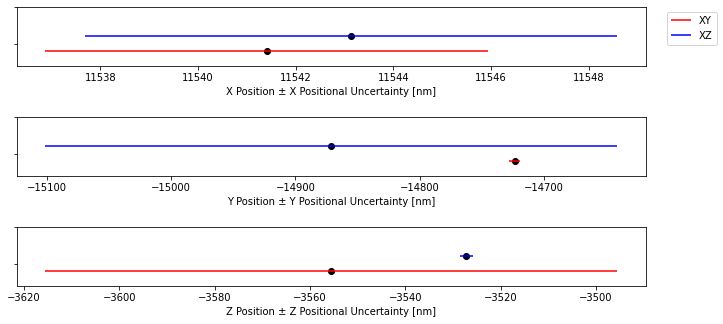

In [13]:
# Only used for this demonstration, not necessary for the software
import matplotlib.pyplot as plt

fig, ([ax1, ax2, ax3]) = plt.subplots(3, 1, figsize=(10,5))
fig.tight_layout(pad=3)

ax1.set_ylim(-3, 5)
ax1.yaxis.set_ticklabels([])
ax1.hlines(-1, (Values.df["X_XY"][0] - Values.df["U_XY"][0]), (Values.df["X_XY"][0] + Values.df["U_XY"][0]), 
           colors="red", label="XY")
ax1.hlines(1, (Values.df["X_XZ"][0] - Values.df["U_X"][0]), (Values.df["X_XZ"][0] + Values.df["U_X"][0]), 
           colors="Blue", label="XZ")
ax1.legend(bbox_to_anchor=(1.12, 1.))
ax1.scatter(Values.df["X_XY"][0], -1, color="Black")
ax1.scatter(Values.df["X_XZ"][0], 1, color="Black")
ax1.set_xlabel(u"X Position \u00B1 X Positional Uncertainty [nm]")

ax2.set_ylim(-3, 5)
ax2.yaxis.set_ticklabels([])
ax2.hlines(-1, (Values.df["Y_XY"][0] - Values.df["U_XY"][0]), (Values.df["Y_XY"][0] + Values.df["U_XY"][0]), 
           colors="red", label="XY")
ax2.hlines(1, (Values.df["Y_XZ"][0] - Values.xypix), (Values.df["Y_XZ"][0] + Values.xypix), 
           colors="Blue", label="XZ")
ax2.scatter(Values.df["Y_XY"][0], -1, color="Black")
ax2.scatter(Values.df["Y_XZ"][0], 1, color="Black")
ax2.set_xlabel(u"Y Position \u00B1 Y Positional Uncertainty [nm]")

ax3.set_ylim(-3, 5)
ax3.yaxis.set_ticklabels([])
ax3.hlines(-1, (Values.df["Z_XY"][0] - Values.zpix), (Values.df["Z_XY"][0] + Values.zpix), 
           colors="red", label="XY")
ax3.hlines(1, (Values.df["Z_XZ"][0] - Values.df["U_Z"][0]), (Values.df["Z_XZ"][0] + Values.df["U_Z"][0]), 
           colors="Blue", label="XZ")
ax3.scatter(Values.df["Z_XY"][0], -1, color="Black")
ax3.scatter(Values.df["Z_XZ"][0], 1, color="Black")
ax3.set_xlabel(u"Z Position \u00B1 Z Positional Uncertainty [nm]")

plt.show()

# Filtering;

<div class="alert alert-block alert-info">
This class is used to filter the position matched events to ensure no duplicate events exist. Duplicate events are seen when one localization from the XY dataframe is position matched with various localizations from the XZ dataframe, or vise versa. Duplicate events can occur most frequently when scanned with the X-ray light sheet tail. <br>
It has been observed that when duplicate events occur, the multiple localizations from a single set have drastically increasing or decreasing positional uncertainty, allowing for the selection of the lowest positional uncertainty as the particle's true location out of all of the duplicates.
</div>

In [14]:
class filtering(object):
    """
    This file is part of the Multi-Orientation MAXWELL software
    
    File author(s): Sierra Dean <ccnd@live.com>
    
    Distributed under the GPLv3 Licence.
    See accompanying file LICENSE.txt or copy at
        http://www.gnu.org/licenses/gpl-3.0.html
        
    source: https://github.com/SierraD/Multi-Orientation-MAXWELL
    
    Last Updated: Sept 26 2024
    """
    def __init__(self, data):
        """
        A technique to obtain precise localizations in 3D space, with data originating 
        from two-dimensional ThunderSTORM analysis performed on mulitple orientations. 
        
        This method uses the overlapped localizations determined by the Overlap.py method and 
        filters all overlapped points to ensure no duplications. The choice of filtering
        includes selecting the lowest uncertainty values, or the most similar intensity
        values. 
        
        The final dataframe obtained from this method is the resulting 3D localizations
        obtained from comparing the two ThunderSTORM orientations.
        
        Attributes:
        data: 
            The data previously developed and contained within the Overlap.py class.
 
        Return:
            None. Will modify the data established in place.
        """
        self.data = data
        return 
    
    def merge(self):
        """
        A technique to group indexes which contain points which overlap with multiple other
        points, which can then be used to filter out duplicates.
        
        Attributes:
            None. 
 
        Return:
            None. Will modify the data established in place.
        """
        unique_XY = numpy.unique(self.data.df["X_XY"])
        unique_XZ = numpy.unique(self.data.df["X_XZ"])
        XY_indexes = []
        XZ_indexes = []
        for i in unique_XZ:
            XZ_indexes.append(numpy.where(self.data.df["X_XZ"]==i)[0].tolist())
        for j in unique_XY:
            XY_indexes.append(numpy.where(self.data.df["X_XY"]==j)[0].tolist())
        all_items = numpy.arange(0, len(self.data.df["X_XZ"]))
        all_indexes = []
        for k in all_items:
            list_all = numpy.array([k])
            for l in list_all:
                list_z = []
                list_y = []
                [list_z.append(sub_list) for sub_list in XZ_indexes if l in sub_list]
                [list_y.append(sub_list) for sub_list in XY_indexes if l in sub_list]
                list_all = numpy.unique(numpy.append(list_all, list_z))
                list_all = numpy.unique(numpy.append(list_all, list_y))
            all_indexes.append(list_all.tolist())
        self.all_indexes = all_indexes
        merged_indexes = []
        for m in all_indexes:
            m = set(m)
            for n in merged_indexes:
                if m & n:
                    n.update(m)
                    break
            else:
                merged_indexes.append(m)
        merged_indexes = [list(o) for o in merged_indexes]
        self.merged_indexes = merged_indexes
        return self
    
    def selection(self, selection_type="uncertainty"):
        """
        A technique to filter all of the indexes which contain overlaps from multiple 
        localizations to remove all non-unique localizations.
                
        Attributes:
        selection_type: str "uncertainty", "Uncertainty", "intensity", "Intensity"
            The method of filtering. If uncertainty is selected, for all overlapped points, 
            only the lowest positional uncertainty point will be kept. If intensity is selected, 
            only the lowest intensity point will be kept.
 
        Return:
            None. Will modify the data established in place.
        """
        if (selection_type=="uncertainty") or (selection_type=="Uncertainty"):
            point_selection = []
            for i in range(0, len(self.merged_indexes)):
                u_xy = []
                u_z = []
                u_x = []
                sumall = []
                for j in self.merged_indexes[i]:
                    u_xy.append(self.data.df["U_XY"][j])
                    u_z.append(self.data.df["U_Z"][j])
                    u_x.append(self.data.df["U_X"][j])
                [sumall.append(sum(s)) for s in zip(*[u_xy, u_z, u_x])]
                loc = numpy.where(sumall==min(sumall))[0]
                point_selection.append(self.merged_indexes[i][loc[0]])
            self.point_indexes = point_selection
        elif (selection_type=="intensity") or (selection_type=="Intensity"):
            point_selection = []
            for i in range(0, len(self.merged_indexes)):
                i_xy = []
                i_xz = []
                sumall = []
                for j in self.merged_indexes[i]:
                    i_xy.append(self.data.df["I_XY"][j])
                    i_xz.append(self.data.df["I_XZ"][j])
                [sumall.append(sum(s)) for s in zip(*[i_xy, i_xz])]
                loc = numpy.where(sumall==min(sumall))[0]
                point_selection.append(self.merged_indexes[i][loc[0]])
            self.point_indexes = point_selection
        return self
    
    def points(self):
        """
        A technique to obtain a dataframe of precise localizations in 3D space, 
        with data originating from two-dimensional ThunderSTORM analysis performed 
        in multiple orientations.
        
        Attributes:
            None.
            
        Return:
            None. Will modify the data established in place.
        """
        df = self.data.df
        for i in range(0, len(df)):
            if i not in (self.point_indexes):
                df = df.drop(i, axis=0)
        self.df = df
        points = pandas.concat([df["X_XY"], df["Y_XY"], df["Z_XZ"], 
                            df["U_XY"], df["U_Z"], 
                            df["S_XY"], df["S_Z"], 
                            df["I_XY"], df["I_XZ"], 
                            df["O_XY"], df["O_XZ"],
                            df["B_XY"], df["B_XZ"]], 
                           keys = ["X [nm]", "Y [nm]", "Z [nm]", 
                                   "Uncertainty XY [nm]", "Uncertainty Z [nm]",
                                   "Sigma XY [nm]", "Sigma Z [nm]",
                                   "Intensity XY [Photons]", "Intensity XZ [Photons]",
                                   "Offset XY [Photons]", "Offset XZ [Photons]",
                                   "Bkgstd XY [Photons]", "Bkgstd XZ [Photons]"], axis=1).reset_index(drop=True)
        self.points = points
        return self
    
    def download_dataframe(self, filename="Filtering_Dataframe"):
        """
        A technique to download the data prepared by the Filtering.py method as a 
        CSV file named "Filtering_Dataframe.csv".
        
        Attributes:
            None.
            
        Return:
            None. Will download the dataframe as a CSV file.
        """
        self.points.index.set_names('id', level=None, inplace=True)
        self.points.to_csv(filename+".csv", index=True, encoding='utf-8')
        return self

<div class="alert alert-block alert-success">
This class requires a merge command first, to group events which overlap with multiple other points. Once grouped together, the selection command allows the duplicates to be filtered out either by uncertainty, as described above, which is the recommended selection, or by intensity, which will choose the closest intensity values. <br>
Lastly, the points command is used to determine the three-dimensional localizations, by combining the most accurate information from the position matched events.
</div>

In [15]:
Filtered = filtering(Values)
Filtered = Filtered.merge()
Filtered = Filtered.selection(selection_type="uncertainty")
Filtered = Filtered.points()

<div class="alert alert-block alert-success">
The following code demonstrates how many points are contained within the finalized dataframe, as well as the minimum value for the positional uncertainty in the X and Y directions, as well as the minimum positional uncertainty in the Z direction.
</div>

In [16]:
print(len(Filtered.points["X [nm]"]))
print(min(Filtered.points["Uncertainty Z [nm]"]))
print(min(Filtered.points["Uncertainty XY [nm]"]))

98
1.100363163786924
3.344546645000296


# Plotting;

<div class="alert alert-block alert-info">
This class is used as a convenient plotting tool which expedites plotting the results from any of the described classes in both two and three-dimensional options. 
</div>

In [17]:
class plotting(object):
    """
    This file is part of the Multi-Orientation MAXWELL software
    
    File author(s): Sierra Dean <ccnd@live.com>
    
    Distributed under the GPLv3 Licence.
    See accompanying file LICENSE.txt or copy at
        http://www.gnu.org/licenses/gpl-3.0.html
        
    source: https://github.com/SierraD/Multi-Orientation-Maxwell
    
    Last Updated: Sept 26 2024
    """
    
    def __init__(self, data):
        """
        A technique to visualize the 2D and 3D results obtained from the method.
        
        Attributes:
        data: 
            The data previously developed and contained within the various classes.
 
        Return:
            A plot displaying the values as specified.
        """
        self.data = data
        return
    
    def onecolumn(self, axis="XY", dimensions=2, scale_by_size=False, show_error=False):
        """
        A technique to visualize the 3D results as a single plot of two dimensional data 
        with the orientation specified, inlcuding the error bars for the localization.
        
        Attributes:
        dimensions: int 2 or 3 
            The dimensions of the data, either 2D for the XY/XZ data or 3D for the finalized data.
        scale_by_size: list [100, 100], etc
            The dimensions to be used for the width and height of the figure.
        show_error: bool
            True or False for showing the error bars.
 
        Return:
            A plot displaying the localizations as a single plot of two-dimensional data.
        """
        fig = plotly.graph_objects.Figure()
        if type(scale_by_size) == list:
            fig.update_layout(autosize=False, width=scale_by_size[0], height=scale_by_size[1])
        if axis == "XY":
            if dimensions == 2:
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxy["X_XY"], y=self.data.dfxy["Y_XY"], name="XY",
                                         error_x=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                      visible=show_error, width=1, color="gray"), 
                                         error_y=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                      visible=show_error, width=1, color="gray"),
                                         marker=dict(color="Red", size=2), mode="markers"))
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxz["X_XZ"], y=self.data.dfxz["Y_XZ"], name="XZ",
                                     error_x=dict(type='data', array=self.data.dfxz["U_X"], 
                                                  visible=show_error, width=1, color="gray"), 
                                         marker=dict(color="Blue", size=2), mode="markers"))

            elif dimensions == 3:
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.points["X [nm]"], y=self.data.points["Y [nm]"],
                                     error_x=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Black", size=2), mode="markers", showlegend=False))
        elif axis == "XZ":
            if dimensions == 2:
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxy["X_XY"], y=self.data.dfxy["Z_XY"], 
                                         error_x=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                      visible=show_error, width=1, color="gray"), 
                                         marker=dict(color="Red", size=2), mode="markers", showlegend=False))
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxz["X_XZ"], y=self.data.dfxz["Z_XZ"], 
                                         error_x=dict(type='data', array=self.data.dfxz["U_X"], 
                                                      visible=show_error, width=1, color="gray"), 
                                         error_y=dict(type='data', array=self.data.dfxz["U_Z"], 
                                                      visible=show_error, width=1, color="gray"),    
                                         marker=dict(color="Blue", size=2), mode="markers", showlegend=False))
            elif dimensions == 3:
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.points["X [nm]"], y=self.data.points["Z [nm]"],
                                     error_x=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.points["Uncertainty Z [nm]"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Black", size=2), mode="markers", showlegend=False))
        elif axis == "YZ":
            if dimensions == 2:
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxy["Y_XY"], y=self.data.dfxy["Z_XY"], 
                                         error_x=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                      visible=show_error, width=1, color="gray"), 
                                         marker=dict(color="Red", size=2), mode="markers", showlegend=False))
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxz["Y_XZ"], y=self.data.dfxz["Z_XZ"], 
                                         error_y=dict(type='data', array=self.data.dfxz["U_Z"], 
                                                      visible=show_error, width=1, color="gray"),    
                                         marker=dict(color="Blue", size=2), mode="markers", showlegend=False))
            elif dimensions == 3:
                fig.add_trace(plotly.graph_objects.Scatter(x=self.data.points["Y [nm]"], y=self.data.points["Z [nm]"],
                                     error_x=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.points["Uncertainty Z [nm]"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Black", size=2), mode="markers", showlegend=False))
        fig.show()
        return self
    
    def tricolumn(self, dimensions=2, scale_by_size=False, show_error=False):
        """
        A technique to visualize the 3D results as three columns of two dimensional data, 
        inlcuding the error bars for the localization.
        
        Attributes:
        dimensions: int 2 or 3 
            The dimensions of the data, either 2D for the XY/XZ data or 3D for the finalized data.
 
        Return:
            A plot displaying the localizations as three columns of two-dimensioanl data.
        """
        fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=("XY Orientation", 
                                                                            "XZ Orientation", 
                                                                            "YZ Orientation"), 
                                            horizontal_spacing = 0.1)
        if type(scale_by_size) == list:
            fig.update_layout(autosize=False, width=scale_by_size[0], height=scale_by_size[1])
        if dimensions == 2:
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxy["X_XY"], y=self.data.dfxy["Y_XY"], name="XY",
                                     error_x=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Red", size=2), mode="markers"), row=1, col=1)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxz["X_XZ"], y=self.data.dfxz["Y_XZ"], name="XZ",
                                     error_x=dict(type='data', array=self.data.dfxz["U_X"], 
                                                  visible=show_error, width=1, color="gray"), 
                                 marker=dict(color="Blue", size=2), mode="markers"), row=1, col=1)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxy["X_XY"], y=self.data.dfxy["Z_XY"], 
                                     error_x=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     marker=dict(color="Red", size=2), mode="markers", showlegend=False), row=1, col=2)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxz["X_XZ"], y=self.data.dfxz["Z_XZ"], 
                                     error_x=dict(type='data', array=self.data.dfxz["U_X"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.dfxz["U_Z"], 
                                                  visible=show_error, width=1, color="gray"),    
                                     marker=dict(color="Blue", size=2), mode="markers", showlegend=False), row=1, col=2)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxy["Y_XY"], y=self.data.dfxy["Z_XY"], 
                                     error_x=dict(type='data', array=self.data.dfxy["U_XY"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     marker=dict(color="Red", size=2), mode="markers", showlegend=False), row=1, col=3)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.dfxz["Y_XZ"], y=self.data.dfxz["Z_XZ"], 
                                     error_y=dict(type='data', array=self.data.dfxz["U_Z"], 
                                                  visible=show_error, width=1, color="gray"),    
                                     marker=dict(color="Blue", size=2), mode="markers", showlegend=False), row=1, col=3)
        elif dimensions == 3:
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.points["X [nm]"], y=self.data.points["Y [nm]"],
                                     error_x=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Black", size=2), mode="markers", showlegend=False), row=1, col=1)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.points["X [nm]"], y=self.data.points["Z [nm]"],
                                     error_x=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.points["Uncertainty Z [nm]"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Black", size=2), mode="markers", showlegend=False), row=1, col=2)
            fig.add_trace(plotly.graph_objects.Scatter(x=self.data.points["Y [nm]"], y=self.data.points["Z [nm]"],
                                     error_x=dict(type='data', array=self.data.points["Uncertainty XY [nm]"], 
                                                  visible=show_error, width=1, color="gray"), 
                                     error_y=dict(type='data', array=self.data.points["Uncertainty Z [nm]"], 
                                                  visible=show_error, width=1, color="gray"),   
                                     marker=dict(color="Black", size=2), mode="markers", showlegend=False), row=1, col=3)
        fig.update_xaxes(title_text="X [nm]", row=1, col=1, title_standoff = 0)
        fig.update_yaxes(title_text="Y [nm]", row=1, col=1, title_standoff = 0)
        fig.update_xaxes(title_text="X [nm]", row=1, col=2, title_standoff = 0)
        fig.update_yaxes(title_text="Z [nm]", row=1, col=2, title_standoff = 0)
        fig.update_xaxes(title_text="Y [nm]", row=1, col=3, title_standoff = 0)
        fig.update_yaxes(title_text="Z [nm]", row=1, col=3, title_standoff = 0)
        fig.show()
        return self
    
    def tricolumn_sigma(self, dimensions=2, scale_by_size=False):
        """
        A technique to visualize the 3D results as three columns of two dimensional data, 
        with the size of the markers represented as the sigma value obtained from ThunderSTORM.
        
        Attributes:
        dimensions: int 2 or 3 
            The dimensions of the data, either 2D for the XY/XZ data or 3D for the finalized data.
 
        Return:
            A plot displaying the localizations as three columns of 2D data visualized as the ThunderSTORM sigma value.
        """
        if dimensions == 2:
            fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=("XY Orientation", "XZ Orientation"))
            if type(scale_by_size) == list:
                fig.update_layout(autosize=False, width=scale_by_size[0], height=scale_by_size[1])
            left_x_xy = self.data.dfxy["X_XY"] - self.data.dfxy["S_XY"]
            right_x_xy = self.data.dfxy["X_XY"] + self.data.dfxy["S_XY"]
            left_y = self.data.dfxy["Y_XY"] - self.data.dfxy["S_XY"]
            right_y = self.data.dfxy["Y_XY"] + self.data.dfxy["S_XY"]
            left_x_xz = self.data.dfxz["X_XZ"] - self.data.dfxz["S_X"]
            right_x_xz = self.data.dfxz["X_XZ"] + self.data.dfxz["S_X"]
            left_z = self.data.dfxz["Z_XZ"] - self.data.dfxz["S_Z"]
            right_z = self.data.dfxz["Z_XZ"] + self.data.dfxz["S_Z"]
            for i in range(0, len(left_x_xy)): 
                fig.add_shape(type="circle", x0=left_x_xy[i], x1=right_x_xy[i], y0=left_y[i], y1=right_y[i], 
                              fillcolor="red", line_color="red", opacity=0.2, row=1, col=1)
            for j in range(0, len(left_x_xz)): 
                fig.add_shape(type="circle", x0=left_x_xz[j], x1=right_x_xz[j], y0=left_z[j], y1=right_z[j], 
                              fillcolor="Blue", line_color="Blue", opacity=0.2, row=1, col=2)
            fig.update_xaxes(range=[min(left_x_xy)+((min(right_x_xy)-max(left_x_xy))/4),
                                max(right_x_xy)-((min(right_x_xy)-max(left_x_xy))/4)], row=1, col=1)
            fig.update_yaxes(range=[min(left_y)+((min(right_y)-max(left_y))/4),
                                max(right_y)-((min(right_y)-max(left_y))/4)], row=1, col=1)
            fig.update_xaxes(range=[min(left_x_xz)+((min(right_x_xz)-max(left_x_xz))/4),
                                max(right_x_xz)-((min(right_x_xz)-max(left_x_xz))/4)], row=1, col=2)
            fig.update_yaxes(range=[min(left_z)+((min(right_z)-max(left_z))/4),
                                max(right_z)-((min(right_z)-max(left_z))/4)], row=1, col=2)
            fig.show()
        elif dimensions == 3:
            fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=("XY Orientation", 
                                                                                "XZ Orientation", 
                                                                                "YZ Orientation"))
            if type(scale_by_size) == list:
                fig.update_layout(autosize=False, width=scale_by_size[0], height=scale_by_size[1])
            left_x = self.data.points["X [nm]"] - self.data.points["Sigma XY [nm]"]
            right_x = self.data.points["X [nm]"] + self.data.points["Sigma XY [nm]"]
            left_y = self.data.points["Y [nm]"] - self.data.points["Sigma XY [nm]"]
            right_y = self.data.points["Y [nm]"] + self.data.points["Sigma XY [nm]"]
            left_z = self.data.points["Z [nm]"] - self.data.points["Sigma Z [nm]"]
            right_z = self.data.points["Z [nm]"] + self.data.points["Sigma Z [nm]"]
            for i in range(0, len(left_x)): 
                fig.add_shape(type="circle", x0=left_x[i], x1=right_x[i], y0=left_y[i], y1=right_y[i], 
                              fillcolor="Black", line_color="Black", opacity=0.4, row=1, col=1)
                fig.add_shape(type="circle", x0=left_x[i], x1=right_x[i], y0=left_z[i], y1=right_z[i], 
                              fillcolor="Black", line_color="Black", opacity=0.4, row=1, col=2)
                fig.add_shape(type="circle", x0=left_y[i], x1=right_y[i], y0=left_z[i], y1=right_z[i], 
                              fillcolor="Black", line_color="Black", opacity=0.4, row=1, col=3)
            fig.update_xaxes(range=[min(left_x)+((min(right_x)-max(left_x))/4),
                                max(right_x)-((min(right_x)-max(left_x))/4)], row=1, col=1)
            fig.update_yaxes(range=[min(left_y)+((min(right_y)-max(left_y))/4),
                                max(right_y)-((min(right_y)-max(left_y))/4)], row=1, col=1)
            fig.update_xaxes(range=[min(left_x)+((min(right_x)-max(left_x))/4),
                                max(right_x)-((min(right_x)-max(left_x))/4)], row=1, col=2)
            fig.update_yaxes(range=[min(left_z)+((min(right_z)-max(left_z))/4),
                                max(right_z)-((min(right_z)-max(left_z))/4)], row=1, col=2)
            fig.update_xaxes(range=[min(left_y)+((min(right_y)-max(left_y))/4),
                                max(right_y)-((min(right_y)-max(left_y))/4)], row=1, col=3)
            fig.update_yaxes(range=[min(left_z)+((min(right_z)-max(left_z))/4),
                                max(right_z)-((min(right_z)-max(left_z))/4)], row=1, col=3)
            fig.show()
        return self
    
    def three_dimensional(self, dimensions=2, scale_by_size=False):
        """
        A technique to visualize the 3D results of the localizations.
        
        Attributes:
        dimensions: int 2 or 3 
            The dimensions of the data, either 2D for the XY/XZ data or 3D for the finalized data.
 
        Return:
            A 3D visualization of the localizations.
        """
        fig = plotly.graph_objects.Figure()
        if type(scale_by_size) == list:
            fig.update_layout(width=scale_by_size[0], height=scale_by_size[1])
        if dimensions == 2:
            fig.add_trace(plotly.graph_objects.Scatter3d(x=self.data.dfxy["X_XY"], 
                                                         y=self.data.dfxy["Y_XY"], 
                                                         z=self.data.dfxy["Z_XY"],
                                       name = "XY",
                                       marker=dict(color="#FF2D00", size=2), mode="markers"))
            fig.add_trace(plotly.graph_objects.Scatter3d(x=self.data.dfxz["X_XZ"], 
                                                         y=self.data.dfxz["Y_XZ"], 
                                                         z=self.data.dfxz["Z_XZ"],
                                       name = "XZ",
                                       marker=dict(color="#001BFF", size=2), mode="markers"))
        elif dimensions == 3:
            fig.add_trace(plotly.graph_objects.Scatter3d(x=self.data.points["X [nm]"], 
                                                         y=self.data.points["Y [nm]"], 
                                                         z=self.data.points["Z [nm]"],
                                       marker=dict(color="#000000", size=2), mode="markers"))
        fig.show()
        return self
    
    def three_dimensional_sigma(self, dimensions=3, scale_by_size=False):
        """
        A technique to visualize the 3D results of the localizations, 
        with the size represented as the sigma value obtained from ThunderSTORM.
        
        Attributes:
        dimensions: int 2
            The dimensions of the data, should be 3D for the finalized data.
 
        Return:
            A 3D visualization of the localizations with the size represented as the 
            sigma value obtained from ThunderSTORM.
        """
        if dimensions != 3:
            raise ValueError("The PSF is only three dimensional after the data has been converted to three dimensions.")
        u, v = numpy.mgrid[0:2*numpy.pi:20j, 0:numpy.pi:10j]
        fig = plotly.subplots.make_subplots(rows=1, cols=1, specs=[[{'is_3d': True}]])
        if type(scale_by_size) == list:
            fig.update_layout(width=scale_by_size[0], height=scale_by_size[1])
        for i in range(0,len(self.data.points["X [nm]"])):
            x = self.data.points["Sigma XY [nm]"][i]*numpy.cos(u)*numpy.sin(v)+self.data.points["X [nm]"][i]
            y = self.data.points["Sigma XY [nm]"][i]*numpy.sin(u)*numpy.sin(v)+self.data.points["Y [nm]"][i]
            z = self.data.points["Sigma Z [nm]"][i]*numpy.cos(v)+self.data.points["Z [nm]"][i]
            fig.add_trace(plotly.graph_objects.Surface(x=x, y=y, z=z, opacity=0.5), 1, 1)
        fig.update_traces(showscale=False)
        fig.update_layout(scene = dict(xaxis_title="X [nm]", yaxis_title="Y [nm]", zaxis_title="Z [nm]"))
        fig.show()
        return

<div class="alert alert-block alert-success">
The code to initiate the Plotting.py class. This class requires one parameter, which is a dataframe of localizations created by any of the described classes.
</div>

In [18]:
# For data from Filtering.py:
Visualize = plotting(Filtered)
# For data from Overlap.py:
Overlap_Visualize = plotting(Values) 
# For data from Preparation.py:
Prepare_Visualize = plotting(Data)

<div class="alert alert-block alert-success">
The Tricolumn command can be used to visualize the data using three two-dimensional plots, showing XY, XZ, and YZ orientations. For this command, if the data being plotted is the results from the Overlap.py or Preparation.py classes, the dimensions option should be set to 2, as the data is two sets of two dimensional data. Conversely, if the data being plotted is from the Filtering.py class, the dimensions option should be set to 3, as the data is three dimensional. <br>
The following are Tricolumn plots obtained from the dataframe obtained from Filtering.py (Top), Overlap.py (Middle), and Preparation.py (Bottom). For the plots containing localizations from various orientations, the XY is depicted in red, and XZ in blue.
</div>

In [19]:
Visualize = Visualize.tricolumn(dimensions = 3)
Overlap_Visualize = Overlap_Visualize.tricolumn(dimensions = 2)
Prepare_Visualize = Prepare_Visualize.tricolumn(dimensions = 2)

<div class="alert alert-block alert-success">
For the Tricolumn command, the data is visualized with an assigned point size, to save computational time, but using the Tricolumn_Sigma command instead, the points will be visualized by their individual standard deviation values of the Gaussian fitted on the peak during localization, understood as the unique point spread function of the localization, which is more computationally demanding.
</div>

In [20]:
Visualize = Visualize.tricolumn_sigma(dimensions = 3)

<div class="alert alert-block alert-success">
Similarly, the Three_dimensional command can be used to visualize all localizations from the Filtering.py dataframe, with an arbitrary point size. The Three_dimensional_sigma command allows the points to be visualized from their point spread functions.
</div>

In [21]:
Visualize = Visualize.three_dimensional(dimensions = 3, scale_by_size=[800, 800])

In [22]:
Visualize = Visualize.three_dimensional_sigma(dimensions = 3, scale_by_size=[800, 800])

# Precision;

<div class="alert alert-block alert-info">
This class is used to determine the method precision for the analyzed data. The precision can be generated for the Bkgstd, Uncertainty, or Sigma columns from the Filtering.py class, as these values are all standard deviation values.<br>
To perform the analysis, a histogram is created of the chosen data, which is then fit with PDF fittings from common distributions to find the most accurate fit for the data. The PDF provides insights into the histogram properties. In the case of standard deviation results, the precision can be obtained by determining the most likely value of the standard deviation, which will be the peak of the PDF fitting applied to the histogram.
</div>

In [23]:
class precision(object):
    """
    This file is part of the Multi-Orientation MAXWELL software
    
    File author(s): Sierra Dean <ccnd@live.com>
    
    Distributed under the GPLv3 Licence.
    See accompanying file LICENSE.txt or copy at
        http://www.gnu.org/licenses/gpl-3.0.html
        
    source: https://github.com/SierraD/Multi-Orientation-Maxwell
    
    Last Updated: Sept 26 2024
    """
    def __init__(self, data, data_type="Uncertainty XY [nm]"):
        """
        A technique to automatically obtain the precision of the method. 
        
        The data returned by ThunderSTORM (i.e. Uncertainty, Sigma) are standard deviation 
        values obtained by fitting the fluorescent spot many times, and therefore the sigma
        value obtained from this deviation can be interpreted as the method precision. 
        
        To calculate the method precision, the histogram of the data is automatically 
        compared with Probability Distribution Functions (PDF) from known distributions 
        (i.e. Normal, Chi2, Exponential, etc.), then the best fit is selected by minimizing 
        the Sum of the Square Error between the histogram and the PDF.
        
        
        Attributes:
        data: 
            The data previously developed and contained within the filtering class.
 
        Return:
            None. Will modify the data established in place.
        """
        self.data = data
        self.data_type = data_type
        self.points = self.data.points
        self.height = data.points[data_type].values
        self.best_fit = "norm"
        return
    
    def get_precision(self, distribution=fitter.get_common_distributions()):
        """
        A technique to generate a histogram from specified data, and compare with PDF fittings from 
        known distributions. 
        
        A plot of the data is automatically generated, and up to five PDF distributions, selected 
        by minizming the Sum of the Square Error, are plotted in conjunction.
                
        Attributes:
        data: str "Uncertainty XY [nm]", "Uncertainty Z [nm]", "Sigma XY [nm]", "Sigma Z [nm]", etc.
            The data to be used for the histogram and the fitting.
        distribution: str "norm", "lognorm", get_common_distributions(), get_distributions(), etc.
            The type of distribution to be used for the fitting.
            If none specified, all common distributions (10) will be compared.
            
        Return:
            None. Will modify the data established in place.
        """
        fit = fitter.Fitter(self.height, distributions=distribution)
        fit.fit()
        print(fit.summary())
        self.best_fit = list(fit.get_best().keys())[0]
        print("\nBest Fit Selected: ", self.best_fit)
        return self
    
    def fitted_precision(self, kde=False, bins=30, distribution=False):
        """
        A technique to automatically obtain the precision of data using either the determined or 
        specified best fit from known distributions. 
        
        A plot of the data is automatically generated, with the specified PDF plotted in 
        conjunction, in addition to displaying useful values related to method precision.
        
        Attributes:
        kde: bool 
            The decision to also display the Kernel Density Estimation (KDE) of the histogram.
        bins: int
            The number of bins to be used for the final histogram.
        distribution: False or str "norm", "lognorm", etc.
            Eiter False, which will automatically use the best fit determined by the 
            'get_precision' method, or a string specifying the known distribution to 
            perform a PDF comparison with.

        Return:
            A plot displaying the histogram and important variables.
        """
        if distribution == False:
            distribution = self.best_fit
        else: 
            distribution = distribution
        
        fit = fitter.Fitter(self.height, distributions=distribution)
        fit.fit()
        fit.summary()
        xmin, xmax = matplotlib.pyplot.xlim()
        self.Xaxis = numpy.linspace(xmin, xmax, 1000)
        
        params = list(fit.fitted_param[distribution]) 
        best_fitted = eval("scipy.stats." + distribution)
        fitting = best_fitted.pdf(self.Xaxis, *params)
        
        fig0, ax0 = matplotlib.pyplot.subplots(figsize=(10,5))
        ax0.set_title("Precision Analysis")
        ax0.set_ylabel("Density")
        ax0.set_xlabel(self.data_type)
        seaborn.histplot(x=self.points[self.data_type], ax=ax0, stat="density", kde=kde, bins=bins, linewidth=0.5, 
                     label=("N="+str(len(self.points[self.data_type]))), 
                     line_kws={'label': "Kernel Density Estimation (KDE) Fitting"})
        ax0.plot(self.Xaxis, fitting, color="red", linestyle="dashed", 
                 label="Probability Density Function (PDF) Fitting")
        a = round(self.Xaxis[numpy.where(fitting == fitting.max())][0], 4)
        b = round(fitting[numpy.where(fitting == fitting.max())][0], 4)
        ax0.scatter(a, b, color="red", label=("σ = "+str(a)+" [nm]"))
        ax0.legend()
        matplotlib.pyplot.show()
        return self

<div class="alert alert-block alert-success">
The code to initiate the Precision.py class. This class requires a dataframe of three-dimensional localizations, formatted in the Filtering.py class, as well as a column specified by the data_type parameter.
</div>

In [24]:
InDepth_Precision = precision(Filtered, data_type="Uncertainty Z [nm]")

<div class="alert alert-block alert-success">
The get_precision command is used to obtain a histogram of the specified data column, then fit the histogram with PDF distributions. If the most accurate distribution is not known, the distribution parameter can be specified as distribution = fitter.get_distributions(), which will fit the histogram with various distributions, which are visible in the Python Fitter Package documentation [https://pypi.org/project/fitter/]. If no distribution is specified, only the Fitter common distributions will be fit. If the best fit option is known, the distribution can be set to save computation time.
</div>

              sumsquare_error         aic         bic  kl_div  ks_statistic  \
norminvgauss         13.88973  336.197606  346.537476     inf      0.074514   

              ks_pvalue  
norminvgauss   0.620843  

Best Fit Selected:  norminvgauss


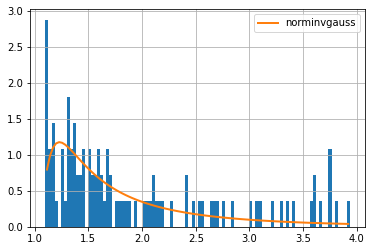

In [25]:
InDepth_Precision = InDepth_Precision.get_precision(distribution="norminvgauss")

<div class="alert alert-block alert-success">
The fitted_precision command is used to fit the histogram with the best fit determined, and to obtain the histogram properties. This command includes the kde parameter, which will also fit the histogram with a Kernel Density Estimate for reference. In addition, the number of histogram bins can be specified with bins, and the best fit distribution determined with the previous command should be specified.<br>
Shown below is the histogram and PDF fitting obtained from the Precision.py dataframe, depicting the results from the Uncertainty Z [nm] column. The localizations are depicted as a histogram, with the specified column displayed on the X axis. The number of events is recorded in the legend. The chosen PDF, a Normal Inverse Gaussian for this example, is plotted in red, with the maximum value of the PDF fitting shown as a red circle. The precision is described as the maximum value of the PDF fit on a histogram of standard deviation values.
</div>

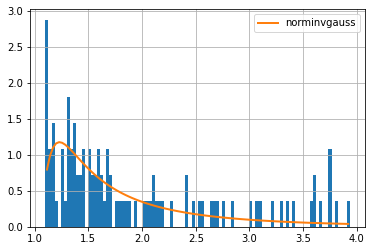

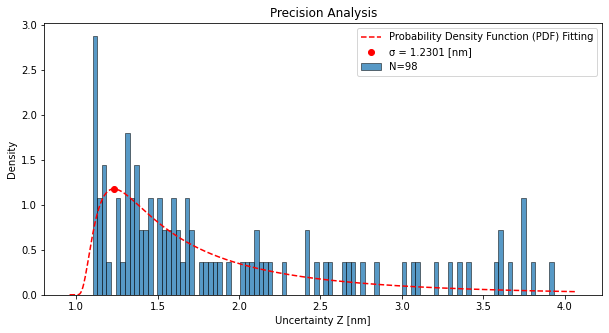

In [26]:
InDepth_Precision = InDepth_Precision.fitted_precision(kde=False, bins=100, distribution="norminvgauss")

<div class="alert alert-block alert-success">
This command can be repeated for other columns, to determine the precision for other localization values as well, such as the positional uncertainty in the X and Y directions.
</div>

      sumsquare_error          aic          bic  kl_div  ks_statistic  \
burr         0.333999  1500.496955  1510.836825     inf      0.080205   

      ks_pvalue  
burr   0.527615  

Best Fit Selected:  burr


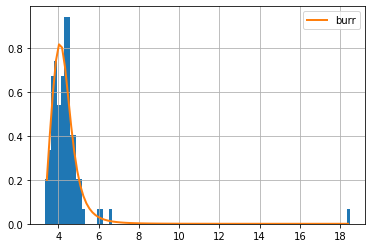

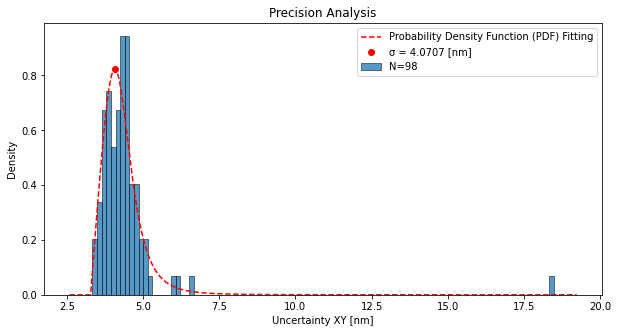

In [27]:
XY_Precision = precision(Filtered, data_type="Uncertainty XY [nm]")
XY_Precision = XY_Precision.get_precision(distribution="burr")
XY_Precision = XY_Precision.fitted_precision(kde=False, bins=100, distribution="burr")